In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('games.csv')
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


# Data Preprocessing

In [4]:
df.isna().any()

id                False
rated             False
created_at        False
last_move_at      False
turns             False
victory_status    False
winner            False
increment_code    False
white_id          False
white_rating      False
black_id          False
black_rating      False
moves             False
opening_eco       False
opening_name      False
opening_ply       False
dtype: bool

## Openings

In [5]:
df['opening_name'].nunique()

1477

In [6]:
df['opening_name'].value_counts().head(20)

opening_name
Van't Kruijs Opening                             368
Sicilian Defense                                 358
Sicilian Defense: Bowdler Attack                 296
Scotch Game                                      271
French Defense: Knight Variation                 271
Scandinavian Defense: Mieses-Kotroc Variation    259
Queen's Pawn Game: Mason Attack                  232
Queen's Pawn Game: Chigorin Variation            229
Scandinavian Defense                             223
Horwitz Defense                                  209
Caro-Kann Defense                                199
Philidor Defense #3                              198
Philidor Defense #2                              193
Indian Game                                      181
Italian Game: Anti-Fried Liver Defense           180
Four Knights Game: Italian Variation             176
Modern Defense                                   174
Owen Defense                                     168
King's Pawn Game: Wayward Queen A

We can see that some openings contains #2 or #3 in their names. But it doesn't exist officially in Chess so we have to clean it.

In [7]:
def clean_opening_name(name):
    return re.sub(r'\s+#\d+$', '', name.strip())

df['opening_name'] = df['opening_name'].apply(clean_opening_name)

df['opening_name'].value_counts().head(20)

opening_name
Philidor Defense                                 554
Sicilian Defense                                 417
Van't Kruijs Opening                             368
Queen's Pawn Game                                316
Sicilian Defense: Bowdler Attack                 296
Scotch Game                                      271
French Defense: Knight Variation                 271
Scandinavian Defense: Mieses-Kotroc Variation    259
Queen's Pawn Game: Mason Attack                  232
Queen's Pawn Game: Chigorin Variation            229
Scandinavian Defense                             223
Pirc Defense                                     212
Horwitz Defense                                  209
Caro-Kann Defense                                203
Indian Game                                      181
Italian Game: Anti-Fried Liver Defense           180
Four Knights Game: Italian Variation             176
Modern Defense                                   174
Owen Defense                     

In [8]:
df['opening_name'].nunique()

1403

### Display the top 10 openings with the highest white and black win rate

White win rate

In [9]:
df_win = df[df['winner'].isin(['white', 'black'])].copy()

df_win['white_win'] = (df_win['winner'] == 'white').astype(int)
opening_counts = df_win['opening_name'].value_counts()

# Only openings with more than 20 games
valid_openings = opening_counts[opening_counts >= 20].index
df_filtered = df_win[df_win['opening_name'].isin(valid_openings)]
white_winrate = df_filtered.groupby('opening_name')['white_win'].mean()
white_winrate_sorted = white_winrate.sort_values(ascending=False)
print(white_winrate_sorted.head(10))


opening_name
Nimzowitsch Defense: Scandinavian Variation |  Advance Variation         0.826087
Russian Game: Damiano Variation                                          0.800000
English Opening: Agincourt Defense                                       0.785714
Ruy Lopez: Exchange Variation |  Lutikov Variation                       0.740741
Zukertort Opening: Queen's Gambit Invitation                             0.740000
King's Gambit Accepted |  MacLeod Defense                                0.730769
English Opening: King's English Variation |  Reversed Closed Sicilian    0.714286
Ruy Lopez: Morphy Defense |  Caro Variation                              0.710526
King's Pawn Game: Busch-Gass Gambit                                      0.709091
Ruy Lopez: Berlin Defense |  Improved Steinitz Defense                   0.708333
Name: white_win, dtype: float64


Black win rate

In [10]:
df_win['black_win'] = (df_win['winner'] == 'black').astype(int)
opening_counts = df_win['opening_name'].value_counts()

# Only openings with more than 20 games
valid_openings = opening_counts[opening_counts >= 20].index
df_filtered = df_win[df_win['opening_name'].isin(valid_openings)]
black_winrate = df_filtered.groupby('opening_name')['black_win'].mean()
black_winrate_sorted = black_winrate.sort_values(ascending=False)
print(black_winrate_sorted.head(10))

opening_name
Kadas Opening                                       0.777778
Grob Opening                                        0.777778
King's Pawn Game                                    0.740741
Sicilian Defense: Paulsen Variation                 0.720000
Sicilian Defense: Modern Variations |  Main Line    0.700000
Mieses Opening: Reversed Rat                        0.692308
French Defense: King's Indian Attack                0.687500
King's Pawn Game: Macleod Attack                    0.666667
Italian Game: Schilling-Kostic Gambit               0.657895
King's Pawn Game: King's Head Opening               0.655172
Name: black_win, dtype: float64


We can see that depending on the opening, either White or Black has a higher chance of winning.

## Elo Difference

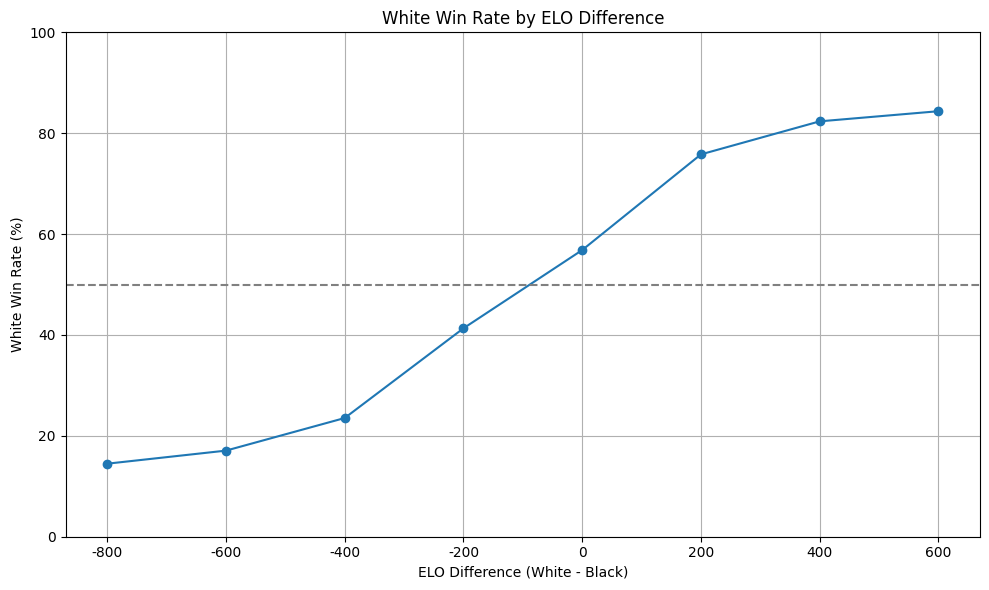

In [11]:
bins = [-800, -600, -400, -200, 0, 200, 400, 600, 800]
labels = bins[:-1]  # use lower bounds as labels

df['elo_diff'] = df['white_rating'] - df['black_rating']
df['elo_range'] = pd.cut(df['elo_diff'], bins=bins, labels=labels, include_lowest=True, right=False)

# Calculate white win rate per ELO range
white_win_rate = (
    df[df['winner'] == 'white']
    .groupby('elo_range', observed=True)
    .size() / df.groupby('elo_range', observed=True).size()
) * 100

# Plotting
plt.figure(figsize=(10, 6))
white_win_rate.plot(marker='o', linestyle='-')
plt.axhline(50, ls='--', color='gray')  # ligne à 50%
plt.title('White Win Rate by ELO Difference')
plt.xlabel('ELO Difference (White - Black)')
plt.ylabel('White Win Rate (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

# Machine Learning

In [12]:
df = df[df['winner'].isin(['white', 'black'])].copy()

df['elo_diff'] = df['white_rating'] - df['black_rating']
df['elo_diff_scaled'] = df['elo_diff'] / 100

#We keep only the top 100 openings playing
valid_openings = df['opening_name'].value_counts()
valid_openings = valid_openings[valid_openings >= 100].index
df = df[df['opening_name'].isin(valid_openings)].copy()

openings = df['opening_name'].unique()
opening_map = {name: i for i, name in enumerate(openings)}
df['opening_encoded'] = df['opening_name'].map(opening_map)

df['winner_encoded'] = df['winner'].map({'black': 0, 'white': 1})

# Features
X = df[['elo_diff_scaled', 'opening_encoded']]
y = df['winner_encoded']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0  # pour éviter les logs de XGBoost pendant l'entraînement
)

model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy : {acc}")


Accuracy : 0.6596820809248555


<Figure size 600x600 with 0 Axes>

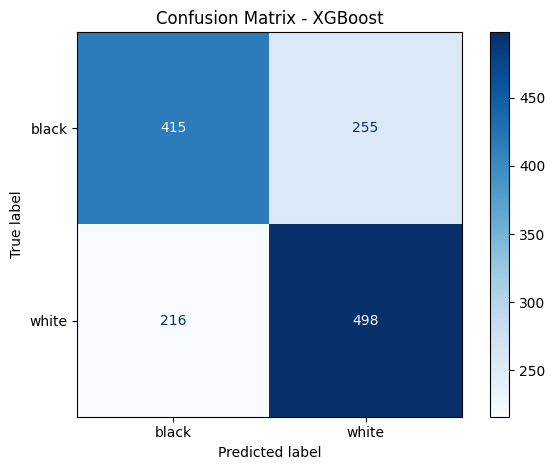

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['black', 'white']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.tight_layout()
plt.show()


In [14]:
# Example input
white_rating = 2000
black_rating = 1950
opening_name = "Hungarian Opening"

elo_diff_scaled = (white_rating - black_rating) / 100

# Check if the opening is known
if opening_name in opening_map:
    opening_encoded = opening_map[opening_name]
    features = np.array([[elo_diff_scaled, opening_encoded]])

    # Predict probabilities
    proba = model.predict_proba(features)[0]
    print(f"Probability of WHITE winning: {proba[1]*100:.2f}%")
    print(f"Probability of BLACK winning: {proba[0]*100:.2f}%")
    # Predicted label
    predicted_label = 'white' if proba[1] > proba[0] else 'black'
    print(f"→ Predicted winner: {predicted_label.upper()}")

else:
    print("Opening not recognized.")


Probability of WHITE winning: 33.87%
Probability of BLACK winning: 66.13%
→ Predicted winner: BLACK


In [15]:
# Example input
white_rating = 2000
black_rating = 1900
opening_name = "Hungarian Opening"

elo_diff_scaled = (white_rating - black_rating) / 100

# Check if the opening is known
if opening_name in opening_map:
    opening_encoded = opening_map[opening_name]
    features = np.array([[elo_diff_scaled, opening_encoded]])

    # Predict probabilities
    proba = model.predict_proba(features)[0]
    print(f"Probability of WHITE winning: {proba[1]*100:.2f}%")
    print(f"Probability of BLACK winning: {proba[0]*100:.2f}%")
    # Predicted label
    predicted_label = 'white' if proba[1] > proba[0] else 'black'
    print(f"→ Predicted winner: {predicted_label.upper()}")

else:
    print("Opening not recognized.")


Probability of WHITE winning: 50.33%
Probability of BLACK winning: 49.67%
→ Predicted winner: WHITE


## Limit of the model

The model can’t predict mistakes, time pressure, etc.
Draws were excluded.
